In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import tjy_udf as tjy
mpl.rc_file('tjy.mplstyle')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
DISPLAY_SORTED = True

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import ticker

###COOLWARM COLORMAP DOCUMENTATION  
#https://depts.washington.edu/airqual/coolwarm.m
#Base blue: RGB = [59 76 192]
#Base red:  RGB = [180 4 38]
warm_red = [180/255, 4/255, 38/255]
cool_blue = [59/255,76/255,192/255]
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [2]:
#From Erika: sequences.docx; phosphorylation s,t from 03/15 email
L_seq = "MGCETRLSFTSVGSITSGYSQSSQVFGRSAYSGLQsSSYLMsARAFPAYYTSHVQEEQSEVEETIEATKAEEAKDEPPSEGEAEEEEKEKEEGEEEEGAEEEEAAKDESEDAKEEEGGEGEEEDTKESEEEEKKEESAGEEQAAKKKDLEHHHHHH"
M_seq = "GSSHHHHHHSsGLVPRGSHMCWYSTFSGSITGPLYTHRQPSVtISSKIQKTKVEAPKLKVQHKFVEEIIEETKVEDEKSEMEDALTVIAEELAASAKEEKEEAEEKEEEPEVEKsPVKsPEAKEEEEGEKEEEEEGQEEEEEEDEGVKSDQAEEGGSEKEGSSEKDEGEQEEEGETEAEGEGEEAEAKEEKKTEGKVEEMAIKEEIKVEKPEKAKsPVPKsPVEEVKPKPEAKAGKDEQKEEEKVEEKKEVAKEsPKEEKVEKKEEKPKDVPDKKKAESPVKEKAVEEMITITKSVKVSLEKDTKEEKPQQQEKVKEKAEEEGGSEEEVGDKsPQESKKEDIAINGEVEGKEEEEQETQEKGSGQEEEKGVVTNGLDVSPAEEKKGEDRSDDKVVVTKKVEKITSEGGDGATKYITKSVTVTQKVEEHEETFEEKLVSTKKVEKVTSHAIVKEVTQGD"
H_seq = "MGCWYMSEFTSMSTHIKVKSEEKIKVVEKSEKETVIVEEQTEEIQVTEEVTEEEDKEAQGEEEEEAEEGGEEAATTSPPAEEAAsPEKETKSPVKEEAKsPAEAKsPAEAKsPAEAKsPAEVKsPAVAKsPAEVKsPAEVKsPAEAKsPAEAKsPAEVKsPATVKsPGEAKsPAEAKsPAEVKsPVEAKsPAEAKsPAsVKsPGEAKsPAEAKsPAEVKsPATVKsPVEAKsPAEVKsPVTVKsPAEAKsPVEVKsPAsVKsPSEAKsPAGAKsPAEAKsPVVAKsPAEAKsPAEAKPPAEAKsPAEAKsPAEAKsPAEAKsPAEAKsPVEVKsPEKAKSPVKEGAKsLAEAKsPEKAKsPVKEEIKPPAEVKsPEKAKsPMKEEAKsPEKAKTLDVKsPEAKtPAKEEAKRPADIRsPEQVKsPAKEEAKsPEKEETRTEKVAPKKEEVKsPVEEVKAKEPPKKVEEEKTPATPKTEVKESKKDEAPKEAQKPKAEEKEPLTEKPKDsPGEAKKEEAKEKKAAAPEEETPAKLGVKEEAKPKEKAEDAKAKEPSKPSEKEKPKKEEVPAAPEKKDTKEEKTTESKKPEEKPKMEAKAKEEDKGLPQEPSKPKTEKAEKSSSTDQKDSQPSEKAPEDKLLEHHHHHH"

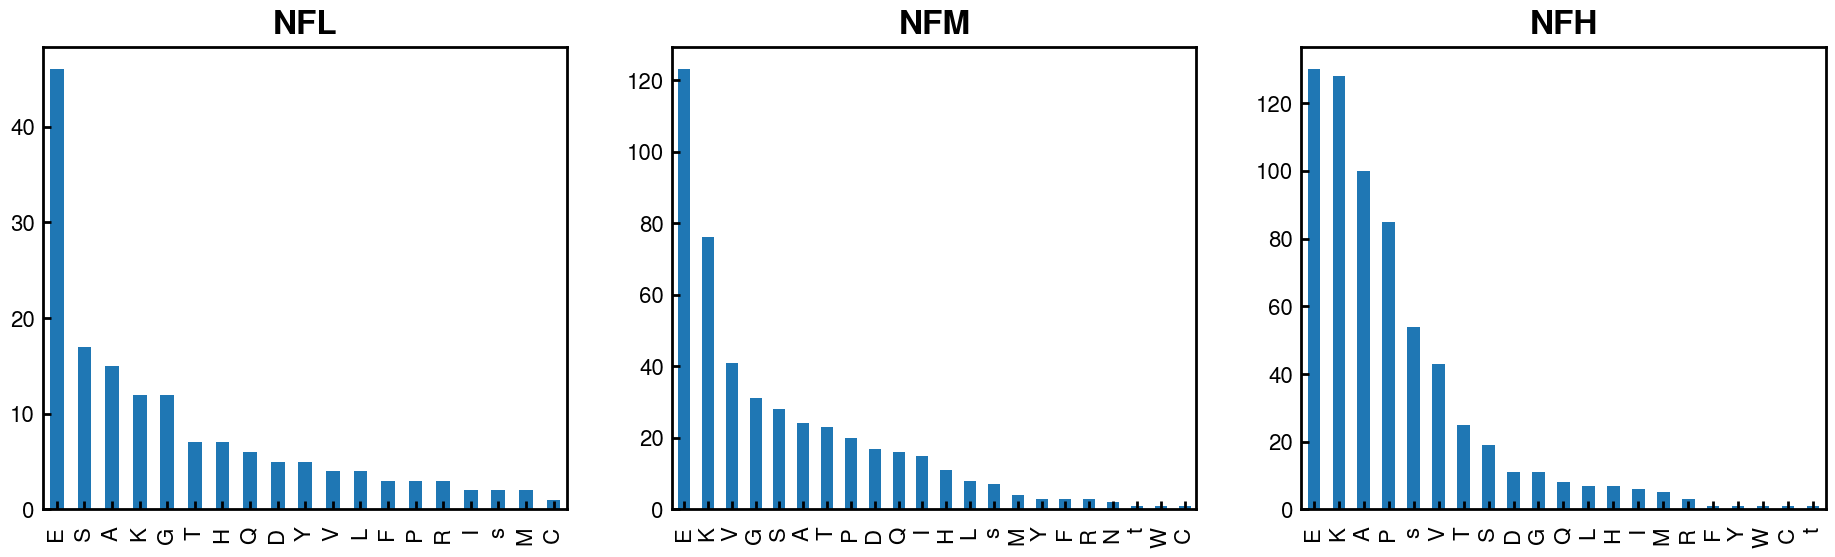

In [7]:
f, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(23, 6))
L_AA = [i for i in L_seq]
M_AA = [i for i in M_seq]
H_AA = [i for i in H_seq]
AA = [L_AA, M_AA, H_AA]
name = ['NFL', 'NFM', 'NFH']
for i in range(len(AA)):
  pd.Series(AA[i]).value_counts().plot(ax = ax[i], kind='bar')
  ax[i].set_title(name[i], fontweight="bold")
plt.show()

In [6]:
aa_b = 3.6e-1; #nanometer units, source: "https://bionumbers.hms.harvard.edu/bionumber.aspx?s=n&v=5&id=114332"

In [69]:
def charge_dist(sequence):
  charge_dist = []
  for i in sequence:
    charge_dist.append(aa_to_charge(i))

  return charge_dist

def aa_to_charge(aa):
  switcher = {
      "E": -1,
      "R": +1,
      "K": +1,
      "D": -1,
      "H": +0, #+1 #not part of original gene
  }
  return switcher.get(aa, 0) #If not in switcher, charge = 0

def charge_dist_ph(sequence, ph, phos=False):
  charge_dist = []
  for i in sequence:
    charge_dist.append(aa_to_charge_ph(i, ph, phos))

  return charge_dist

def aa_to_charge_ph(aa, ph, phos=False):
    #Source: https://www.sigmaaldrich.com/US/en/technical-documents/technical-article/protein-biology/protein-structural-analysis/amino-acid-reference-chart
    pKa = {
      #"G": [2.34, 9.60],
      #"A": [2.34, 9.69],
      #"V": [2.32, 9.62],
      #"L": [2.36, 9.60],
      #"I": [2.36, 9.60],
      #"M": [2.28, 9.21],
      #"F": [1.83, 9.13],
      #"W": [2.38, 9.39],
      #"P": [1.99, 10.60],
      #"S": [2.21, 9.15],
      #"T": [2.09, 9.10],
      #"N": [2.02, 8.80],
      #"Q": [2.17, 9.13],
      #"C": [1.96, 10.28, 8.18],
      #"Y": [2.20, 9.11, 10.07],
      #"D": [1.88, 9.60, 3.65],
      #"E": [2.19, 9.67, 4.25],
      #"K": [2.18, 8.95, 10.53],
      #"R": [2.17, 9.04, 12.48],
      #"H": [1.82, 9.17, 6.00],

      #"C": [8.18],
      #"Y": [10.07],
      "D": [3.65, -1*np.inf],
      "E": [4.25, -1*np.inf],
      "K": [np.inf, 10.53],
      "R": [np.inf, 12.48],
      "H": [np.inf, 6.00],
    }

    #Henderson Hasselbalch
    ## HH --> pH  - pKa = log10([base]/[acid])

    #Example: pH 2.4 / pOH 11.6
    ## [D]: 2.4 - 3.65 = -1.25 = log10([A-]/[HA]) -->  [A-]/[HA] = 0.056 
    ##      --> ch = Z- * [A-]/([A-] + [HA])  = -0.053
    ## [K]: 11.6 - 10.53 = 1.07 = log10([BH+]/[B]) --> [BH+]/[B] = 11.75
    ##      --> ch = X+ * [BH+]/([BH+] + [B]) = +0.92

    a_ha = 10**(ph - pKa.get(aa,[np.inf]*2)[0])
    bh_b = 10**(-1*(ph-pKa.get(aa,[-1*np.inf]*2)[1]))
    
    if phos and (aa == 's' or aa == 't'):
        ch = -1.5 ## ASSUMPTION of -1.5 for phosphorylated 
    else: 
        ch = bh_b/(1 + bh_b) - a_ha/(1 + a_ha)
    

    ##WITHOUT H-H
    # ch = 0
    # if (ph > pKa.get(aa, [ph, ph])[0]): ch += -1
    # if (ph < pKa.get(aa, [ph, ph])[1]): ch += 1
  
    return ch



def chi_dist(sequence):
  chi_dist = []
  for i in sequence: 
    chi_dist.append(aa_to_chi(i))

  return chi_dist

def aa_to_chi(aa):
  chi_max = 3.20
  switcher = {
      "G": chi_max, "P": chi_max, "C": chi_max, "M": chi_max, "A": chi_max, "L": chi_max, "V": chi_max, "I": chi_max,
      "Y": 0.6, "Q": 0.6, "H": 0.6, "F": 0.6, "W": 0.6, 
      "E": 0.0, "D": 0.0, "N": 0.0, #N (Asparagine added, polar uncharged)
      "K": 0.0, "R": 0.0,
      "S": 0.6, "T": 0.6, 
      "s": 0.6, "t": 0.6 #phosphorylated S and T
  }
  return switcher.get(aa, "ERROR: {:s}".format(aa))

In [19]:
print(aa_to_charge_ph("R", 2.40))

0.9999999999168236


In [45]:
def find_charge_avg(sequence, NsK_list):
  Num_blocks = len(NsK_list)

  start = 0
  end = 0
  Nsi = len(sequence)
  L_final = []
  L_dist = charge_dist(sequence)

  for i in range(Num_blocks):
    NsK = NsK_list[i]
    end += NsK
    avg = sum(L_dist[start:end])/NsK

    print("Charge Block {:d}: [{:d} {:d}] = {:.6f}".format(i+1, start, end, avg))
    L_inter = (np.ones(NsK)*avg).tolist()
    L_final += L_inter
    start += NsK
  return L_final

def find_charge_avg_ph(sequence, NsK_list, ph, phos=False):
  Num_blocks = len(NsK_list)

  start = 0
  end = 0
  Nsi = len(sequence)
  L_final = []
  L_dist = charge_dist_ph(sequence, ph, phos)

  for i in range(Num_blocks):
    NsK = NsK_list[i]
    end += NsK
    avg = sum(L_dist[start:end])/NsK

    print("Charge Block {:d}: [{:d} {:d}] = {:.6f}".format(i+1, start, end, avg))
    L_inter = (np.ones(NsK)*avg).tolist()
    L_final += L_inter
    start += NsK
  return L_final

def find_chi_avg(sequence, NsK_list):
  Num_blocks = len(NsK_list)

  start = 0
  end = 0
  Nsi = len(sequence)
  L_final = []
  L_dist = chi_dist(sequence)

  for i in range(Num_blocks):
    NsK = NsK_list[i]
    end += NsK
    avg = sum(L_dist[start:end])/NsK

    print("Chi Block {:d}: [{:d} {:d}] = {:.6f}".format(i+1, start, end, avg))
    L_inter = (np.ones(NsK)*avg).tolist()
    L_final += L_inter
    start += NsK
  return L_final

def Norm_cumsum(sequence):
  L_cumsum = np.cumsum(charge_dist(sequence)[0:len(sequence)])
  if (abs(min(L_cumsum)) > abs(max(L_cumsum))): 
    L_cumsum_max = abs(min(L_cumsum))
  else:
    L_cumsum_max = abs(max(L_cumsum))
  return L_cumsum / L_cumsum_max

def Norm_cumsum_ph(sequence, ph, phos=False):
  L_cumsum = np.cumsum(charge_dist_ph(sequence, ph, phos)[0:len(sequence)])
  if (abs(min(L_cumsum)) > abs(max(L_cumsum))): 
    L_cumsum_max = abs(min(L_cumsum))
  else:
    L_cumsum_max = abs(max(L_cumsum))
  return L_cumsum / L_cumsum_max

In [47]:
def Discr_cumsum(sequence, block_N, smear):
  N = len(sequence)
  x = np.linspace(0,N,N)
  y = np.asarray(Norm_cumsum(sequence))

  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)

  cmap = plt.cm.coolwarm #CHOOSE CMAP TYPE
  cmaplist = [cmap(i) for i in range(cmap.N)] # extract all colors from the .jet map
  cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N) #new cmap

  dydx = np.ndarray(0)
  for i in range(round(N/smear)-1):
    m = (Norm_cumsum(sequence)[(i+1)*smear]-Norm_cumsum(sequence)[i*smear])/smear
    dydx = np.concatenate([dydx, m*np.ones(smear)], axis = 0)

  i = N-smear*(round(N/smear)-1)
  m = (Norm_cumsum(sequence)[N-1]-Norm_cumsum(sequence)[N-i-1])/smear
  dydx = np.concatenate([dydx, m*np.ones(i)], axis = 0)

  zero_thresh = 10
  norm_set = [dydx.min()]
  for i in range(block_N-1):
    m = (dydx.max() - dydx.min())/block_N
    norm_set += [(i+1)*m + dydx.min()]
    if abs((i+1)*m + dydx.min()) < zero_thresh:
      zero = i
      zero_thresh = abs((i+1)*m + dydx.min())
  norm_set += [dydx.max()]

  norm = BoundaryNorm(norm_set, cmap.N)
  lc = LineCollection(segments, lw=5, cmap=cmap, norm=norm, zorder = 5, label="_no_label") #Bring to front of plot
  lc.set_array(dydx)
  return [lc, dydx, norm_set]


In [49]:
def Discr_cumsum_ph(sequence, block_N, smear, ph, phos=False):
  N = len(sequence)
  x = np.linspace(0,N,N)
  y = np.asarray(Norm_cumsum_ph(sequence, ph, phos))

  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)

  cmap = plt.cm.magma #CHOOSE CMAP TYPE
  cmaplist = [tjy.lighten_color(cmap(i), 0.8) for i in range(int(0.75*cmap.N))] # 0.70 * since don't want yellow
  cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N) #new cmap

  dydx = np.ndarray(0)
  for i in range(round(N/smear)-1):
    m = (Norm_cumsum_ph(sequence, ph, phos)[(i+1)*smear]-Norm_cumsum_ph(sequence, ph, phos)[i*smear])/smear
    dydx = np.concatenate([dydx, m*np.ones(smear)], axis = 0)

  i = N-smear*(round(N/smear)-1)
  m = (Norm_cumsum_ph(sequence, ph, phos)[N-1]-Norm_cumsum_ph(sequence, ph, phos)[N-i-1])/smear
  dydx = np.concatenate([dydx, m*np.ones(i)], axis = 0)

  zero_thresh = 10
  norm_set = [dydx.min()]
  for i in range(block_N-1):
    m = (dydx.max() - dydx.min())/block_N
    norm_set += [(i+1)*m + dydx.min()]
    if abs((i+1)*m + dydx.min()) < zero_thresh:
      zero = i
      zero_thresh = abs((i+1)*m + dydx.min())
  norm_set += [dydx.max()]

  norm = BoundaryNorm(norm_set, cmap.N)
  lc = LineCollection(segments, lw=3, cmap=cmap, norm=norm, zorder = 5, label="_no_label") #Bring to front of plot
  lc.set_array(dydx)
  return [lc, dydx, norm_set]


In [25]:
cmap = plt.cm.magma #CHOOSE CMAP TYPE
cmaplist = [tjy.lighten_color(cmap(i), 0.6) for i in range(cmap.N)] # extract all colors from the .jet map
print(cmaplist[-1])

cmaplist = [tjy.lighten_color(cmap(i), 0.6) for i in range(int(cmap.N*0.80))] # extract all colors from the .jet map
print(cmaplist[-1])

(0.9922317999999999, 0.9948627999999999, 0.8497024)
(0.9965854, 0.7701994, 0.6537700000000001)


In [27]:
def find_charge_change(seq_dydx, seq_normset):
  prev = -1
  prev_count = 0
  change_s = []
  for (count, i) in enumerate(seq_dydx):
    curr = 0
    for j in range(len(seq_normset)-1): 
      if seq_normset[j] <= i < seq_normset[j+1]: curr = j
      if j+1 == len(seq_normset)-1: 
        if seq_normset[j] <= i <= seq_normset[j+1]: curr = j
      
    if (curr != prev) & (count!=0): 
      change_s += [count]
      prev_count = count
    prev = curr
  change_s += [len(dydx)]
  return change_s

In [28]:
#Custom block monomers

M_NsK_s = [round(len(M_seq)/5), round(2*len(M_seq)/5), round(3*len(M_seq)/5), round(4*len(M_seq)/5), len(M_seq)]
H_NsK_s = [round(len(H_seq)/5), round(2*len(H_seq)/5), round(3*len(H_seq)/5), round(4*len(H_seq)/5), len(H_seq)]

M_NsK = [M_NsK_s[0]] + [M_NsK_s[i+1] - M_NsK_s[i] for i in range(len(M_NsK_s)-1)] 
H_NsK = [H_NsK_s[0]] + [H_NsK_s[i+1] - H_NsK_s[i] for i in range(len(H_NsK_s)-1)] 

Charge Block 1: [0 35] = 0.000972
Charge Block 2: [35 70] = -0.485419
Charge Block 3: [70 315] = -0.293915
Charge Block 4: [315 455] = -0.192910
Charge Block 5: [455 647] = -0.019795
Charge Block 1: [0 35] = 0.000972
Charge Block 2: [35 70] = -0.485419
Charge Block 3: [70 315] = -0.293915
Charge Block 4: [315 455] = -0.192910
Charge Block 5: [455 647] = -0.019795
Chi Block 1: [0 35] = 1.211429
Chi Block 2: [35 70] = 1.017143
Chi Block 3: [70 315] = 1.708571
Chi Block 4: [315 455] = 1.370000
Chi Block 5: [455 647] = 1.080208


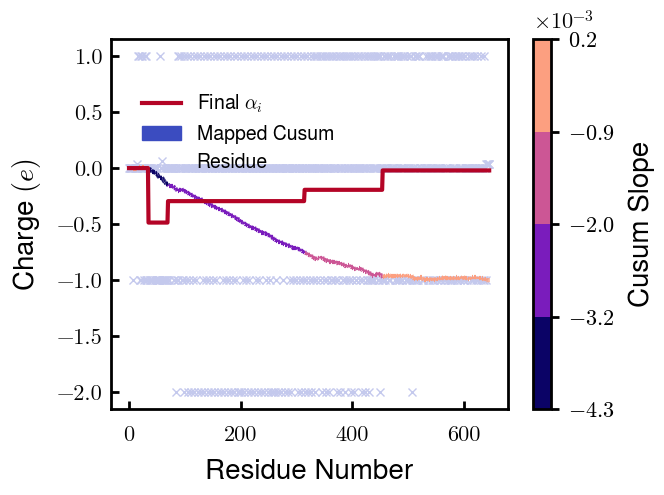

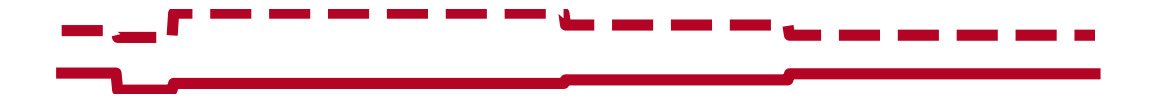

In [91]:
ph = 7.44
seq = H_seq
phos = True

# f, [ax1, ax2] = plt.subplots(nrows = 1, ncols = 2, figsize=(18, 6.5))
f , ax2 = plt.subplots(nrows = 1, ncols = 1)
# ax1.axes.plot(charge_dist_ph(seq, ph), "x", ms=10, mew=3,color=cool_blue, alpha=0.6)
# ax1.axes.plot(Norm_cumsum_ph(seq, ph), color=cool_blue, lw=3)
# ax1.set_title('Raw Sequence', fontweight="bold")
# ax1.set_xlabel("AA Sequence Count")
# ax1.set_ylabel("AA Charge")
# ax1.legend(["AA", "Charge Cumulative Sum"],bbox_to_anchor=(0.01, 0.92), loc="upper left",fontsize=18,frameon=False)

ax2.plot(charge_dist_ph(seq, ph, phos), 'x', color=tjy.lighten_color(cool_blue, 0.3), zorder = 0, mew=1) #Raw Data

smear = 35
block_N = 4

[lc, dydx, norm_set] = Discr_cumsum_ph(seq, block_N, smear, ph, phos)
line = ax2.add_collection(lc) #Cumsum Data

## Scientific Notation with Spec. Precision
class ScalarFormatterClass(ticker.ScalarFormatter):
   def _set_format(self):
      self.format = "$%1.1f$" # New precision

yScalarFormatter = ScalarFormatterClass(useMathText=True)
yScalarFormatter.set_powerlimits((0,0))
cb=f.colorbar(line, label = 'Cusum Slope', format=yScalarFormatter)
cb.ax.yaxis.OFFSETTEXTPAD = 8 # Top padding of sci not
cb.ax.yaxis.set_offset_position('left')
cb.ax.yaxis.offsetText.set_fontsize(16)
cb.ax.yaxis.offsetText.set_fontfamily('Serif')
cb.ax.tick_params(labelsize=16, direction='out')
cb.update_ticks()

NsK_s = find_charge_change(dydx, norm_set)
NsK = [NsK_s[0]] + [NsK_s[i+1] - NsK_s[i] for i in range(len(NsK_s)-1)] #Convert to length of each block
ax2.plot(find_charge_avg_ph(seq, NsK, ph, phos),  '-', color=warm_red, lw=3, zorder = 10) #Final Charge Dist

#ax2.set_title("Block_N={:d}, ".format(block_N)+ r"$\mathbf{Avg_{smear}}$"+" ={:d} points, ".format(smear)+"pH={:.2f}".format(ph), fontweight='bold')
# ax2.set_title("NFH, pH = {:.2f}".format(ph))
ax2.set_xlabel("Residue Number")
ax2.set_ylabel("Charge "r"$(e)$")
tjy.ticks()

custom_legend = [
                  Line2D([0], [0], color=warm_red, ls ='-', lw=3),
                  Patch(color=cool_blue),
                  Line2D([0], [0], color=tjy.lighten_color(cool_blue, 0.30), marker='x', ls='', mew=1)
                ]
ax2.legend(custom_legend,[r"Final $\alpha_{i}$", "Mapped Cusum","Residue"],bbox_to_anchor=(0.01, 0.93), loc="upper left",frameon=False)
plt.savefig('./imgs/NFH_disc.eps')

rect_size = (11/0.75, 1.1) #NFL: (4, 1.5) #NFH: (11/0.75, 1.1)
f = plt.figure(figsize=rect_size)

plt.plot(find_charge_avg_ph(seq, NsK, ph, phos),  '-', color=warm_red, lw=8) #Final Charge Dist
plt.axis('off')

plt.plot(find_chi_avg(seq, NsK),  '--', color=warm_red, lw=8) #Final Charge Dist
# plt.axis('off')
# plt.savefig('H_chi.png', transparent='true')
plt.show()

Charge Block 1: [0 50] = 0.040012
Charge Block 2: [50 75] = -0.358451
Charge Block 3: [75 125] = -0.639707
Charge Block 4: [125 156] = -0.283485


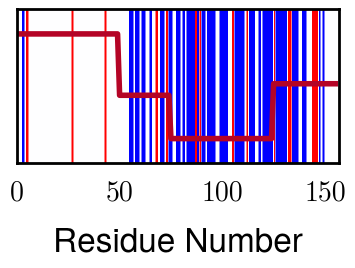

In [90]:
sequence = L_seq
ph = 7.44
phos = True

f, ax = plt.subplots(1,1,figsize=(12,2.00))
cmap = plt.cm.bwr #CHOOSE CMAP TYPE
cmaplist = [cmap(i) for i in range(cmap.N)] # extract all colors from the cmap
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N) #new cmap
N = 5
norm_set = np.linspace(-1,1,N+1)
norm = BoundaryNorm(norm_set, cmap.N)

# Plot Raw
a = charge_dist_ph(sequence, ph, phos)
a = np.expand_dims(a, axis=0)
im = ax.imshow(a, cmap, norm=norm, aspect=75)  

# Plot charge dist
smear = 25
block_N = 4
[lc, dydx, norm_set] = Discr_cumsum_ph(sequence, block_N, smear, ph, phos)
NsK_s = find_charge_change(dydx, norm_set)
NsK = [NsK_s[0]] + [NsK_s[i+1] - NsK_s[i] for i in range(len(NsK_s)-1)] #Convert to length of each block
plt.plot(np.array(find_charge_avg_ph(sequence, NsK, ph, phos))+0.3,  '-', color=warm_red, lw=4) #Final Charge Dist


# Formatting
plt.xlim((0, 157))
plt.ylim((-0.5, 0.5))
plt.xticks(np.arange(0, 157, 50), fontsize="20")
ax.tick_params(length=0)
plt.xlabel("Residue Number", fontsize="24", labelpad=15)
f.set_facecolor("white")

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.get_yaxis().set_visible(False)
tjy.ticks()

# plt.savefig('./imgs/NFH_raw.png', dpi=1600)
# f.colorbar(im)
plt.show()

[31, 31, 31, 372, 62, 93, 27]
Charge Block 1: [0 29] = 0.204967
Charge Block 2: [29 156] = 0.113852
Charge Block 3: [156 261] = 0.169704
Charge Block 4: [261 377] = 0.196115
Charge Block 5: [377 441] = 0.245507
Charge Block 6: [441 493] = 0.284223
Charge Block 7: [493 647] = 0.286612


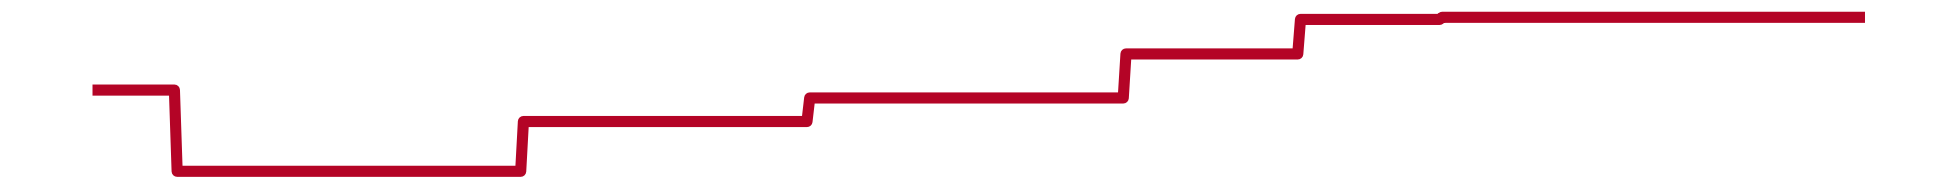

Chi Block 1: [0 31] = 1.180645
Chi Block 2: [31 62] = 0.909677
Chi Block 3: [62 93] = 1.277419
Chi Block 4: [93 465] = 1.495161
Chi Block 5: [465 527] = 1.083871
Chi Block 6: [527 620] = 1.006452
Chi Block 7: [620 647] = 0.844444


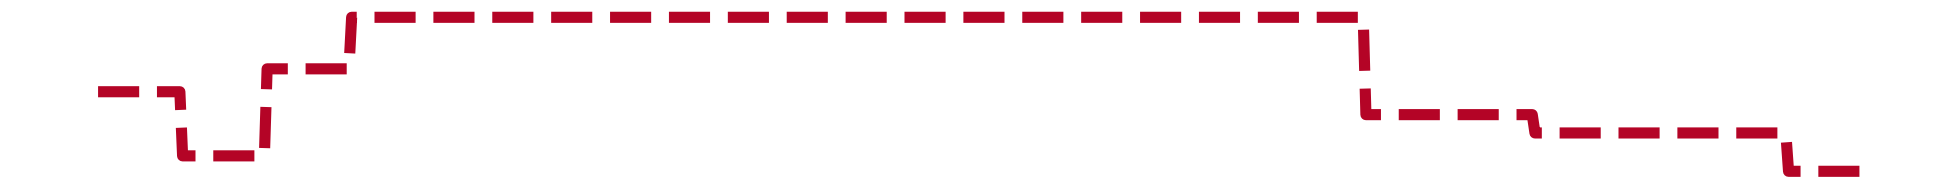

In [ ]:
f = plt.figure(figsize=(25, 2.2))
print(H_NsK)
#H_NsK_new = [29, 87, 145, 116, 29, 87, 154]
dx = 35
H_NsK_new = [29, 87+40, 145-40, 116, 29+dx, 87-dx, 154]
plt.plot(find_charge_avg_ph(H_seq, H_NsK_new, ph),  '-', color=warm_red, lw=8) #Final Charge Dist
plt.axis('off')
plt.show()
f = plt.figure(figsize=(25, 2.2))
plt.plot(find_chi_avg(H_seq, H_NsK),  '--', color=warm_red, lw=8) #Final Charge Dist
plt.axis('off')
plt.show()

Charge Block 1: [0 16] = 0.000100
Charge Block 2: [16 48] = -0.944621
Charge Block 3: [48 116] = -0.210699
Charge Block 1: [0 16] = 0.000100
Charge Block 2: [16 48] = -0.944621
Charge Block 3: [48 116] = -0.210699
Chi Block 1: [0 16] = 0.600000
Chi Block 2: [16 48] = 0.000000
Chi Block 3: [48 116] = 0.176471


AttributeError: 'ScalarFormatter' object has no attribute '_formatSciNotation'

<Figure size 1800x650 with 3 Axes>

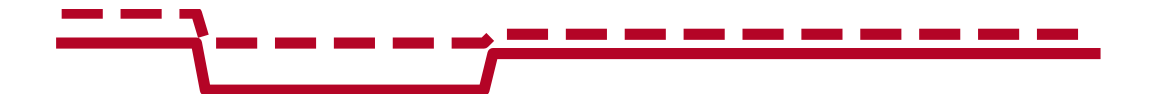

In [35]:
ph = 10
# seq = L_seq
seq = 'HHHHHHHHHHHHHHHHDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDKDDDHHKKDDDHHKKDDDHHKKDDDHHKKDDDHHKKDDDHHKKDDDHHKKDDDHHKKDDDHHKKDDDHHK'

f, [ax1, ax2] = plt.subplots(nrows = 1, ncols = 2, figsize=(18, 6.5))
ax1.axes.plot(charge_dist_ph(seq, ph), "x", ms=10, mew=3,color=cool_blue, alpha=0.6)
ax1.axes.plot(Norm_cumsum_ph(seq, ph), color=cool_blue, lw=4)
ax1.set_title('Cusum')
ax1.set_xlabel("AA Sequence Count")
ax1.set_ylabel("Charge "r"$(e)$")
ax1.legend(["AA", "Charge Cumulative Sum"],bbox_to_anchor=(0.01, 0.92), loc="upper left",fontsize=18,frameon=False)
ax1.set_yticks([-1.0, -0.5, 0, 0.5, 1])

#########
ax2.axes.plot(charge_dist_ph(seq, ph), "x", ms=10, mew=3,color=cool_blue, alpha=0.3)
smear = 16
block_N = 3

[lc, dydx, norm_set] = Discr_cumsum_ph(seq, block_N, smear, ph)
lc.set_alpha(0.75)
line = ax2.add_collection(lc) #Cumsum Data
f1 = ticker.ScalarFormatter(useOffset=False, useMathText=True)
f1.set_scientific(True)
g1 = lambda x,pos : "${}$".format(f1._formatSciNotation('%.0e' % x))
f.colorbar(line, label = "Cusum Slope".format(block_N), 
           format = ticker.FuncFormatter(g1), ax=ax2)

NsK_s = find_charge_change(dydx, norm_set)
NsK = [NsK_s[0]] + [NsK_s[i+1] - NsK_s[i] for i in range(len(NsK_s)-1)] #Convert to length of each block
ax2.plot(find_charge_avg_ph(seq, NsK, ph),  '-', color=warm_red, lw=4, zorder = 10) #Final Charge Dist

#ax2.set_title("Block_N={:d}, ".format(block_N)+ r"$\mathbf{Avg_{smear}}$"+" ={:d} points, ".format(smear)+"pH={:.2f}".format(ph), fontweight='bold')
ax2.set_title("Final Charge Distribution")
ax2.set_xlabel("AA Sequence Count")
ax2.set_ylabel("Charge "r"$(e)$")
ax2.set_yticks([-1.0, -0.5, 0, 0.5, 1])

custom_legend = [
                  # Line2D([0], [0], color=warm_red, ls ='-', lw=3),
                  Line2D([0], [0], color=cool_blue, marker='x', ls='', ms=10, mew=3, alpha=0.3),
                  Patch(color=cool_blue),
                  Line2D([0], [0], color=warm_red, ls ='-', lw=3), 
                  

                ]
ax2.legend(custom_legend,["AA","Mapped Cum. Charge",r"Final $\alpha_{i}$"],bbox_to_anchor=(0.01, 0.92), loc="upper left",fontsize=18,frameon=False)
# ax2.legend(custom_legend,[r"Final $\alpha_{i}$", "Mapped Cum. Charge","Individual Residue"],bbox_to_anchor=(0.01, 0.92), fontsize=18,loc="upper left",frameon=False)

rect_size = (11/0.75, 1.1) #NFL: (4, 1.5) #NFH: (11/0.75, 1.1)
f = plt.figure(figsize=rect_size)

plt.plot(find_charge_avg_ph(seq, NsK, ph),  '-', color=warm_red, lw=8) #Final Charge Dist
plt.axis('off')
plt.savefig('H_charge.png', transparent='true')

plt.plot(find_chi_avg(seq, NsK),  '--', color=warm_red, lw=8) #Final Charge Dist
plt.axis('off')
# plt.savefig('H_chi.png', transparent='true')

plt.show()

In [36]:
def print_aa_str(sequence, sequence_s):
  prev = 0
  count = 1 
  for i in sequence_s:
    print("  Block {}: [{},{}]: {}".format(count, prev, i, sequence[prev:i]))
    print("    Length: {:.2f} nm".format(L_NsK[count-1]*aa_b))
    prev = i
    count += 1
  return

#print("NFLSA")
#print_aa_str(L_seq, L_NsK_s)
#print("NMLSA")
#print_aa_str(M_seq, M_NsK_s)
#print("NHLSA")
#print_aa_str(H_seq, H_NsK_s)

In [37]:
"""
#Custom block monomers
##Zhulina
L_NsK_s = [50, 156] #Zhulina 2007 Charge: [0, -0.254]
M_NsK_s = [448] #Zhulina 2007 Charge: [-0.103]
H_NsK_s = [100, 607] #Zhulina 2007 Charge: [-0.230, 0.043]
H_NsK_s = [607]

L_NsK = [L_NsK_s[0]] + [L_NsK_s[i+1] - L_NsK_s[i] for i in range(len(L_NsK_s)-1)] 
M_NsK = [M_NsK_s[0]] + [M_NsK_s[i+1] - M_NsK_s[i] for i in range(len(M_NsK_s)-1)] 
H_NsK = [H_NsK_s[0]] + [H_NsK_s[i+1] - H_NsK_s[i] for i in range(len(H_NsK_s)-1)] 

rect_size = (10.5/0.75, 0.76)
f = plt.figure(figsize=rect_size)

plt.plot(find_charge_avg(L_seq, L_NsK),  '-', color=warm_red, lw=8) #Final Charge Dist
plt.axis('off')
plt.savefig('check.png', transparent='true')

plt.plot(find_chi_avg(L_seq, L_NsK),  '--', color=warm_red, lw=8) #Final Charge Dist
plt.axis('off')
plt.savefig('check.png', transparent='true')

plt.show()

#plt.plot(find_charge_avg_ph(H_seq, H_NsK, 2.4),  '-', color=warm_red, lw=8) #Final Charge Dist
#plt.axis('off')
#plt.savefig('check.png', transparent='true')

#plt.plot(find_chi_avg(H_seq, H_NsK),  '--', color=warm_red, lw=8) #Final Charge Dist
#plt.axis('off')
#plt.savefig('check.png', transparent='true')

#plt.show()
"""

"\n#Custom block monomers\n##Zhulina\nL_NsK_s = [50, 156] #Zhulina 2007 Charge: [0, -0.254]\nM_NsK_s = [448] #Zhulina 2007 Charge: [-0.103]\nH_NsK_s = [100, 607] #Zhulina 2007 Charge: [-0.230, 0.043]\nH_NsK_s = [607]\n\nL_NsK = [L_NsK_s[0]] + [L_NsK_s[i+1] - L_NsK_s[i] for i in range(len(L_NsK_s)-1)] \nM_NsK = [M_NsK_s[0]] + [M_NsK_s[i+1] - M_NsK_s[i] for i in range(len(M_NsK_s)-1)] \nH_NsK = [H_NsK_s[0]] + [H_NsK_s[i+1] - H_NsK_s[i] for i in range(len(H_NsK_s)-1)] \n\nrect_size = (10.5/0.75, 0.76)\nf = plt.figure(figsize=rect_size)\n\nplt.plot(find_charge_avg(L_seq, L_NsK),  '-', color=warm_red, lw=8) #Final Charge Dist\nplt.axis('off')\nplt.savefig('check.png', transparent='true')\n\nplt.plot(find_chi_avg(L_seq, L_NsK),  '--', color=warm_red, lw=8) #Final Charge Dist\nplt.axis('off')\nplt.savefig('check.png', transparent='true')\n\nplt.show()\n\n#plt.plot(find_charge_avg_ph(H_seq, H_NsK, 2.4),  '-', color=warm_red, lw=8) #Final Charge Dist\n#plt.axis('off')\n#plt.savefig('check.png',

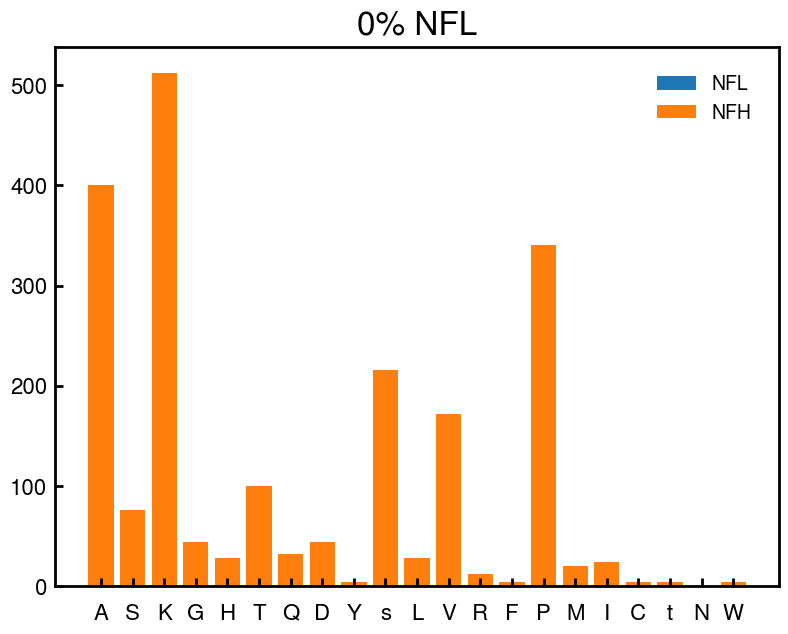

In [38]:
f, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(9.333, 7))

plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["legend.edgecolor"] = '0.0'
plt.rcParams["legend.borderaxespad"] = 1.0

L_FH = [i for i in L_seq if i!=('E'or'D'or'N'or'K'or'R')]
M_FH = [i for i in M_seq if i!=('E'or'D'or'N'or'K'or'R')]
H_FH = [i for i in H_seq if i!=('E'or'D'or'N'or'K'or'R')]

Lc_FH = pd.Series(L_FH).value_counts().multiply(0)
Mc_FH = pd.Series(M_FH).value_counts()
Hc_FH = pd.Series(H_FH).value_counts().multiply(4)
FH = pd.DataFrame([Lc_FH, Mc_FH, Hc_FH]).fillna(0)

ax.set_title('0% NFL')
ax.bar(FH.columns, FH.iloc[0,:], label='NFL')
ax.bar(FH.columns, FH.iloc[2,:], bottom=FH.iloc[0,:], label='NFH')
leg = plt.legend()
leg.get_frame().set_linewidth(2.0)

#plt.ylim([0,80])
plt.show()